# Getting Started Tutorial


First we create a timeseries with two curves between 0 and 10 seconds. The time samples are randomly varied (sample time is not constant). This could be for example results of simulations with an adaptive (variable) step solver.   

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Time samples:
[ 0.          0.09991218  0.19988477  0.29979298  0.39975935  0.4997155
  0.59964329  0.69961123  0.79952734  0.89942771  0.99940688  1.09939913
  1.19938837  1.29931608  1.39928205  1.49919734  1.59910086  1.69901508
  1.79901094  1.89899353  1.99893869  2.09888555  2.19880989  2.29876536
  2.39866781  2.49857068  2.59851835  2.69843765  2.79840728  2.89832152
  2.99829147  3.09824062  3.19817373  3.2980853   3.39798531  3.49789097
  3.59779201  3.69775894  3.79773467  3.8977134   3.99763592  4.09754586
  4.19748951  4.29746265  4.39745613  4.49743229  4.59738694  4.69737199
  4.79735634  4.89728203  4.99728074  5.09718957  5.19713547  5.2970681
  5.39702561  5.497       5.59692137  5.69688327  5.79684173  5.89677631
  5.99670975  6.09663834  6.19659091  6.29656445  6.39653229  6.49649279
  6.596456    6.69643701  6.79642242  6.89632278  6.99623557  7.09623312
  7.196151    7.29610207

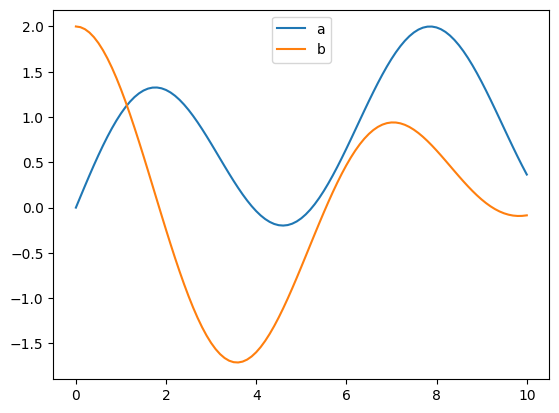

In [42]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, r"D:\User\seberlein\FraunhIEE-UniKassel-PowSysStability\trimes\src")
import trimes
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

t_start = 0
t_end = 10
average_time_step = 0.1
number_of_steps = int(np.round(t_end/average_time_step))
time_steps = average_time_step - (np.random.rand(number_of_steps)*0.001)*average_time_step 
time = np.cumsum(time_steps)
time = np.concatenate(([t_start],time,[np.ceil(time[-1])])) # Make sure that the first time step is zero and the last equals to 10. This is not a generic requirement of trimes, but necessary for this tutorial. 
val_a = np.sin(time) + np.sin(time*0.2)
val_b = np.cos(time) + np.cos(time*0.7)
plt.plot(time, val_a, label="a")
plt.plot(time, val_b, label="b")
plt.legend(loc="upper center")
print("Time samples:")
print(time)

Let's create a pandas DataFrame. *trimes* requires the index to be the time variable. The index can be set at instantiation of the DataFrame or later using 'set_index'.

In [43]:
# Set index at in instantiation
data = {"a": val_a, "b": val_b}
df = pd.DataFrame(data, index=time)
df.index.name = "time"
print("Set index at initialization:")
print(df.head())

# Set index after instantiation
data = {"time": time, "a": val_a, "b": val_b}
df = pd.DataFrame(data)
df.set_index("time", inplace=True)
print("\nSet index after initialization:")
print(df.head())


Set index at initialization:
                 a         b
time                        
0.000000  0.000000  2.000000
0.099912  0.119727  1.992568
0.199885  0.238523  1.970317
0.299793  0.355245  1.933459
0.399759  0.469063  1.882257

Set index after initialization:
                 a         b
time                        
0.000000  0.000000  2.000000
0.099912  0.119727  1.992568
0.199885  0.238523  1.970317
0.299793  0.355245  1.933459
0.399759  0.469063  1.882257


## Geting Data from Transient Time Series

### Get Samples
You can get samples from a DataFrame using the index with the 'loc' method. But the input must be exact. Hence, '0.0' is accepted and returns a pandas Series object because there is a sample at exactly that time. However, '0.55' will throw a key error.

In [44]:
df.loc[0.0] # -> ok, because '0.0' is in df.index
# df.loc[0.55] -> KeyError

a    0.0
b    2.0
Name: 0.0, dtype: float64

The 'get_sample' method of *trimes* returns a pandas Series object with the next sample after the queried time: 

In [45]:
trimes.get_sample(df,0.0) # -> same as df.loc[0.0]
trimes.get_sample(df,0.55)

a    0.683989
b    1.738728
Name: 0.5996432890340507, dtype: float64

'get_sample' and 'get_sample_shifted' accept multiple samples and then return a DataFrame. 'get_sample_shifted' shifts the returned samples. For example the input -1 returns the samples before the sample time:

In [46]:
trimes.get_sample_shifted(df,[0.55, 2],-1)

,a,b
time,,
0.499716,0.578953,1.817160
1.998939,1.298961,-0.244482


You can also query samples around a point in time:

In [47]:
trimes.get_samples_around(df,0.55,-1,2)

,a,b
time,,
0.499716,0.578953,1.817160
0.599643,0.683989,1.738728
0.699611,0.783386,1.647553


This returns the samples from -1 to 2 (relative to first sample after 0.55).

These methods work with DataFrames as well as with Series:

In [48]:
trimes.get_samples_around(df["a"], 0.55, -1, 2)

time
0.499716    0.578953
0.599643    0.683989
0.699611    0.783386
Name: a, dtype: float64

Whereas 'get_sample' returns the values, 'get_index' returns their index (index of first sample after point in time): 

In [49]:
index = trimes.get_index(df, 0.55)
# Then iloc can be used
df.iloc[index] 

a    0.683989
b    1.738728
Name: 0.5996432890340507, dtype: float64

### Interpolation
'interp_df' returns a DataFrame with interpolated (linear) values:

In [50]:
trimes.interp_df(df, [0.5, 3])


,a,b
0.5,0.579252,1.816937
3.0,0.705751,-1.494734


'interp_df' returns a DataFrame even if there is only one sample. You can use 'squeeze' to get a Series object:

In [51]:
trimes.interp_df(df, [0.5]).squeeze(axis=0)

a    0.579252
b    1.816937
Name: 0.5, dtype: float64

'interp_series' does the same with Series input and returns an array:

In [52]:
trimes.interp_series(df["b"], [0.5,0.7])

array([1.8169366 , 1.64715242])

### Slicing
The 'loc' method of pandas works with slices even if the input time does not fit with the samples (9.5 is not in 'time'):

In [53]:
df.loc[9.5:10]

,a,b
time,,
9.595051,0.770533,-0.077975
9.694968,0.666063,-0.087721
9.794878,0.563891,-0.092137
9.894821,0.464925,-0.091362
9.994784,0.370094,-0.085602
10.000000,0.365276,-0.085169


The method 'get_between' of *trimes* works similar and is more performant. Note that one difference between 'loc' and 'get_between' is that 'get_between' returns samples before the last time sample (in this case before 10). 

In [54]:
trimes.get_between(df, 9.5, 10)

,a,b
time,,
9.595051,0.770533,-0.077975
9.694968,0.666063,-0.087721
9.794878,0.563891,-0.092137
9.894821,0.464925,-0.091362
9.994784,0.370094,-0.085602


In [55]:
%timeit df.loc[9.5:10]
%timeit trimes.get_between(df, 9.5, 10)

25 µs ± 712 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
17.5 µs ± 651 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


trimes is more performant because it assumes that the index (time) is monotonously increasing and uses numpy's 'searchsorted' function under the hood.

### Delta between samples
'get_delta' returns the difference between two samples (under the hood, 'get_sample' is used, so the the next sample after the given time is used).

In [56]:
trimes.get_delta(df, 0, 0.5)

a    0.683989
b   -0.261272
dtype: float64

One can also query the delta between interpolated (linear) values:

In [57]:
delta = trimes.get_delta_interp_df(df, 0, 0.5)
print(delta)
trimes.get_delta_interp_series(df["a"], 0, 0.5)

a    0.579252
b   -0.183063
dtype: float64


0.579251693304309

'get_delta_shift' returns the delta between samples around a point in time, in this case between sample 2 before 0.1 and one sample after 0.1:  

In [58]:
trimes.get_delta_shift(df, 0.1, -2, 0)

a    0.238523
b   -0.029683
dtype: float64

In [59]:
trimes.get_delta_interp_df(df,0,0.5)

a    0.579252
b   -0.183063
dtype: float64

## Resampling
The 'resample' method... well you guessed it:

             a         b
0.0   0.000000  2.000000
1.0   1.040115  1.305119
2.0   1.298668 -0.246160
3.0   0.705751 -1.494734
4.0  -0.039360 -1.595740
5.0  -0.117332 -0.652776
6.0   0.652657  0.469792
7.0   1.642306  0.940263
8.0   1.988722  0.630023
9.0   1.385871  0.088826
10.0  0.365276 -0.085169


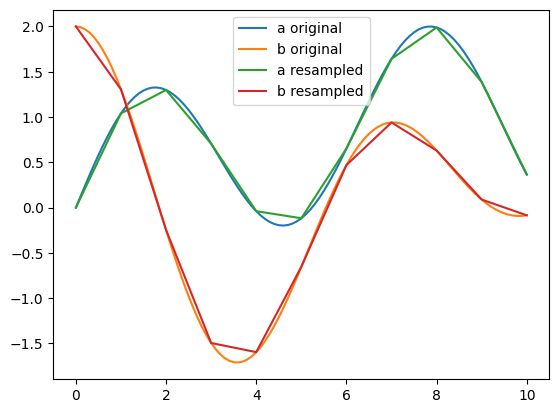

In [60]:
df_resampled = trimes.resample(df, np.arange(0,10.001,1))
print(df_resampled)
plt.plot(df.index, df["a"], label="a original")
plt.plot(df.index, df["b"], label="b original")
plt.plot(df_resampled.index, df_resampled["a"], label="a resampled")
plt.plot(df_resampled.index, df_resampled["b"], label="b resampled")
plt.legend(loc="upper center")